<a href="https://colab.research.google.com/github/Maverick29rus/homework/blob/master/%2216_%D0%9C%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B5%20%D0%B7%D1%80%D0%B5%D0%BD%D0%B8%D0%B5_(Blur_face)%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Навигация по уроку**

1. [Задачи машинного зрения на OpenCV](https://colab.research.google.com/drive/1x1rxbNfV1ft1ztIPwxA3q34J4MULix5A)
2. [OpenCV. Распознавание лиц (практика)](https://colab.research.google.com/drive/1GwMZ8BAjtdKBDA5S0lAX1OPMFmIaYhqL)
3. Домашняя работа


Используя знания из практической части урока и функцию `blur_face` (размытие), проведите следующий эксперимент:
1. Найдите фото любого известного актера или актрисы.
2. Распознайте лицо на фотографии. Выделите лицо овалом. Какой метод для рисования овала использовать, вы должны найти самостоятельно.
3. Выделите на изображении глаза. Выделите их кружком. Если вы чувствуете в себе суперсилу и дополнительный бекграунд знаний, и хотите получить больше баллов за задание, то нарисуйте вместо кружков солнцезащитные очки (картинку очков можно найти в интернете, задача их правильно масштабировать и разместить).
4. Все лицо кроме глаз необходимо "заблюрить" (размыть) с помощью функции `blur_face` (функция объявлена ниже).




Оценка за задание:
* 1 балл - задача решена с помощью куратора, лицо распознано прямоугольником, глаза кругом.
* 2 балла - задача решена с незначительными подсказками куратора, лицо распознано прямоугольником или кругом, глаза кругом, лицо размыто.
* 3 балла - задача решена самостоятельно, лицо распознано овалом, глаза кругом, удалось заблюрить лицо, не затронув глаза.
* 4 балла - задача решена самостоятельно на 3 балла, удалось нарисовать очки с подсказкой куратора, недостаточна соблюдена симметрия расположения очков или недостаточно учтены их размеры.
* 5 баллов - задача полностью решена самостоятельно, все пункты выполнены.

In [ ]:
import cv2
import gdown
import numpy as np
from google.colab.patches import cv2_imshow
from matplotlib import pyplot
# Команда обеспечивает вывод графиков в Google Colaboratory
%matplotlib inline

In [ ]:
gdown.download('https://storage.yandexcloud.net/maverick29rus/face.jpg', None, quiet=True)
gdown.download('https://storage.yandexcloud.net/maverick29rus/sunglasses.png', None, quiet=True)
gdown.download('https://storage.yandexcloud.net/academy.ai/friends.jpg', None, quiet=True)


In [ ]:
# Загрузка изображения
image = cv2.imread('./face.jpg')

# image = cv2.imread('./friends.jpg')

# Загрузим очки
sunglassses = cv2.imread('./sunglasses.png', cv2.IMREAD_UNCHANGED)

# загрузка каскада Хаара для поиска лиц
classifier_face = cv2.CascadeClassifier(cv2.data.haarcascades+ "haarcascade_frontalface_default.xml")

# загрузка каскада Хаара для поиска глаз
classifier_eye = cv2.CascadeClassifier(cv2.data.haarcascades+ "haarcascade_eye.xml")

In [ ]:
# функция размытия
def blur_face(img):
    (h, w) = img.shape[:2]
    dW = int(w / 3.0)
    dH = int(h / 3.0)
    if dW % 2 == 0:
        dW -= 1
    if dH % 2 == 0:
        dH -= 1
    return cv2.GaussianBlur(img, (dW, dH), 0)


In [ ]:
def blur_glass_face(img, glasses, scaleFactor=3, minNeighbors=3,
                    minSize=(50, 50)):

    img2 = img.copy()

    # преобразовываем изображение в черно-белое
    frame_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # выравниваем контрастность
    frame_gray = cv2.equalizeHist(frame_gray)

    # выполнение распознавания лиц
    bboxes = classifier_face.detectMultiScale(frame_gray,
                                              scaleFactor=scaleFactor,
                                              minNeighbors=minNeighbors,
                                              minSize=minSize
                                              )
    if len(bboxes) == 0:
        print("Лицо не распознано")
        return

    # формирование прямоугольника вокруг каждого обнаруженного лица
    for x, y, width, height in bboxes:

        # найденная область с лицом
        face = img2[y:y+height, x:x+width]
        wf = face.shape[1] # ширина лица
        hf = face.shape[0] # высота лица
        center = (hf//2, wf//2) # центр лица

        # создаем маску по размеру лица
        mask_out = np.ones((hf,wf), dtype="uint8") * 255
        # придаем маске форму эллипса (маска оставляет наружнюю часть лица)
        cv2.ellipse(mask_out, center, (wf//3, hf//2), 0, 0, 360, (0, 0, 255), -1)
        # создаем инвертированную маску для внутренней части лица
        mask_in = cv2.bitwise_not(mask_out)

        # выполнение распознавания глаз на чистом лице
        eyes = classifier_eye.detectMultiScale(face)

        if len(eyes) == 0:
            print("Глаза не распознаны")
            return
        elif len(eyes) > 2:
            print("Распознано слишком много глаз")
            return

        # получаем координаты глаз
        (xl, yl, wl, hl), (xr, yr, wr, hr) = eyes
        # выписываем координаты области глаз
        x1=xl-20 # добавляем небольшое смещение чтобы очки лучше смотрелись
        x2=xr+wr+20 # добавляем небольшое смещение чтобы очки лучше смотрелись
        y1=yl
        y2=yl+hl

        # выделяем область глаз
        roi = face[y1:y2, x1:x2]

        # Маштабируем очки до размера глаз
        glass_mask_small = cv2.resize(glasses, (roi.shape[1], roi.shape[0]), interpolation=cv2.INTER_AREA)

        # Извлекаем альфа-канал из изображения солнцезащитных очков и создаем 3-канальный альфа-массив
        alpha_sunglass = glass_mask_small[:, :, 3] / 255.0
        alpha_sunglass = np.stack([alpha_sunglass] * 3, axis=-1)

        # Удаляем альфа-канал из изображения солнцезащитных очков и преобразуем его в BGR
        sunglass_bgr = glass_mask_small[:, :, :3]

        # Выполняем альфа-смешивание, чтобы наложить солнцезащитные очки на лицо
        overlay = (1 - alpha_sunglass) * roi + alpha_sunglass * sunglass_bgr

        # блюрим лицо
        face_blur = blur_face(face)

        # накладываем маску на заблюренное лицо
        blured_face = cv2.bitwise_and(face_blur, face_blur, mask=mask_in)

        # накладываем маску на чистое лицо
        clean_face = cv2.bitwise_and(face, face, mask=mask_out)

        # объединяем заблюреное и чистое лицо
        masked_face = cv2.add(blured_face, clean_face)

        # добавляем очки на замаскированное лицо
        masked_face[y1:y2, x1:x2] = overlay

        # отображение для отладки
        # cv2_imshow(overlay)

        # добавляем замаскированное лицо с очками на оригинальное изображение
        img2[y:y+height, x:x+width] = masked_face

    fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(15, 8))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.xaxis.set_ticks([])
    ax1.yaxis.set_ticks([])
    ax1.set_title('Исходное изображение')

    ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    ax2.xaxis.set_ticks([])
    ax2.yaxis.set_ticks([])
    ax2.set_title('Распознанное заблюренное лицо с очками')

    pyplot.show()


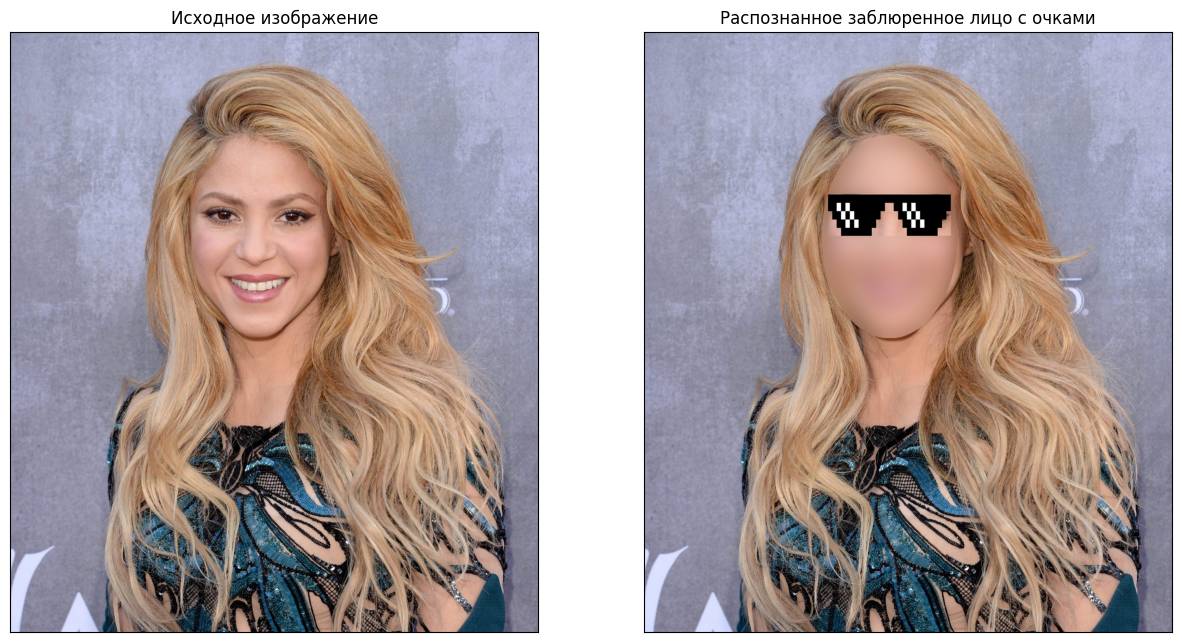

In [ ]:
blur_glass_face(image, sunglassses)